<h1 style="text-align:center;">Quantifying Acne Severity Dynamics - A Bayesian and KL Divergence Framework</h1>
<p style="text-align:center;">By Nathaniel Wolff.</p>



# Analysis Structure and Results

Dataset is found here: https://www.kaggle.com/datasets/manuelhettich/acne04. Consists of n = 10 synthetic patients, 
with acne severity recorded over 112 distinct days of treatment (each indexing a distinct treatment history).


### Analysis Steps
#### 1) Data Parsing -
Base dataframe is seperated by patient. Raw acne severities are normalized as % change relative to patient average baseline intensity.

#### 2) Treatment History Metadata Addition - 
A treatment history metadata column is added to each patient dataframe. Histories are of the form ( (Treatment $a_{1}$, Day 1),...(Treatment $a_{n}$, Day i)), where n is the index of a given treatment in the full history.

#### 3) Kernel Density Estimation of normalized acne severity change -
Over all patient dataframes, the distribution of normalized acne severity over all histories and patients is obtained, and a Kernel Density Estimate is fit.

#### 4) Optimization of KDE and Discretization of Acne Severity Change into 3 states -
The KDE is optimized for local maxima and saddle points; corresponding quantiles define an acne severity change states.  
*In progress: dynamic decision of state number.*

#### 5) Validation of Discretization via Quantile Bootstrapping -
Before binning normalized acne severities into change states, the robustness of binning is assessed via bootstrapping of each quantile. 

#### 6) Calculation of Acne Severity Change State Distribution Series over treatment sequence - 
With an uninformative Dirhclet prior and multinomial likelihood,  posterior distributions of acne severity change states are calculated for each treatment history. 

#### 7) Calculation of information cost between consecutive distributions - 
Kullback-Leibler divergence is calculated between consecutive treatment history posteriors. Cumulative KL divergence represents the information cost of not updating distribution from day to day, a descriptor of distance between distributions. 

#### 8) Determination of Diminishing Returns: Fitting of Univariate Spline to Cumulative KL divergence curve - 
A univariate spline curve is fit to the cumulative KL Divergence of the entire treatment series. The curve's first derivative is evaluated against a threshold ("p value"), returning sections of non-diminishing returns in treatment. 

#### 9) Fitting of Linear Model to Non-Diminishing Treatment Returns' Cumulative KL Divergence
A linear regression model is fit to each non-diminishing return section. Histories are plotted on the x-axis. The systems biology/biochemical implications of these sections are used to determine the form of the predictive model below.


In [2]:
#virtual environment 
! pip install matplotlib pandas scipy numpy seaborn scikit-learn statsmodels filterpy numdifftools

In [3]:
#imports

import matplotlib
import random
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle as rect
from itertools import permutations
from colorsys import rgb_to_hls, hls_to_rgb
import pandas as pd
import scipy as sp
from scipy import optimize
import numpy as np
import seaborn as sns
import copy
from collections import defaultdict, Counter
from matplotlib.cm import viridis
import statsmodels.api as sm
from scipy.stats import dirichlet 
from scipy.stats import beta
from scipy.special import gammaln, psi
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import UnivariateSpline
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KernelDensity
import json
import filterpy as fp
import numdifftools as nd
from functools import partial

In [4]:
def seperate_patients(raw_data):
    """Function that separates the raw dataframe via the following:
    1) Constructs an array tracking where the original date (2018-01-01) recurs.
    2) Uses that array to split raw_data into seperate dataframes.
    """
    #splitting data into different patients using leftmost column index (this is an assumption however)
    seperatePatientsIndices = list(raw_data.index[raw_data["date"] == "2018-01-01"])
    seperatePatientsIndices.append(len(raw_data))

    #checking to see if, after the same number of days in all dataframes, treatment of some sort was introduced
    #verifies that on day 29 
    #then adds the days each additional treatment was added after the fact (turns out they are all the same too)
    allPatientsIntroDays = []
    
    #seperating single dataframe into list of dataframes for each patient
    startIndex = 0
    seperatePatientsDFs = []
    for endIndex in seperatePatientsIndices[1:]:
        seperatePatientsDFs.append(raw_data[startIndex:endIndex])
        startIndex = endIndex
     
    for seperatePatientDF in seperatePatientsDFs:
        treatmentIntroDays =  []
        currentTreatment = seperatePatientDF["treatment"].iloc[0]
          
        for lineIndex in range(1,len(seperatePatientDF)): 
            if seperatePatientDF["treatment"].iloc[lineIndex] != currentTreatment:
                treatmentIntroDays.append([currentTreatment, "end day is", lineIndex])
                currentTreatment  = seperatePatientDF["treatment"].iloc[lineIndex]
                
                
        #remembering the end day of the last treatment and appending to the list
        lastTreatment  = seperatePatientDF["treatment"].iloc[len(seperatePatientDF)-1]
        treatmentIntroDays.append( [lastTreatment, "end day is", len(seperatePatientDF) - 1 ] )
         
        allPatientsIntroDays.append(treatmentIntroDays)
        
    return seperatePatientsDFs, allPatientsIntroDays

In [5]:
def linear_generator_starting_colors(number_treatments, base_colormap = "viridis"):
    """A helper function for display_plots_of_dataset below. Generates n RGB tuples on a linear scale, given the number of treatments.
    Each of these is used as a starting point for a regular map of treatments by day and a blended heatmap of treatments by day, with
    lower lightness for each consecutive day of the same treatment, blended with the last color corresponding to the days of the
    previous treatments."""

    cmap = plt.get_cmap(base_colormap)
    default_colors = [cmap(i / (number_treatments - 1))[:3] for i in range(number_treatments)]
    return default_colors

In [6]:
def blend_old_and_new_color(old_color, new_color, alpha):
    """Another function used by display_plots_of_dataset. Simply blends 2 colors with a given alpha value."""
     # normalize both old and new colors into decimals
    o = np.array(old_color)
    n = np.array(new_color)

    
    o_h, o_l, o_s = rgb_to_hls(*o)
    n_h, n_l, n_s = rgb_to_hls(*n)
    
    # circular interpolation of hue for more effective blending
    hue_diff = ((n_h - o_h + 0.5) % 1.0) - 0.5
    blended_h = (o_h + alpha * hue_diff) % 1.0
    blended_l = (1 - alpha) * o_l + alpha * n_l
    blended_s = (1 - alpha) * o_s + alpha * n_s
    
    blended_rgb = np.array(hls_to_rgb(blended_h, blended_l, blended_s))
    return tuple(blended_rgb)

In [7]:
def display_plots_of_dataset(separate_dfs, patient_intro_days, alpha = .3):
    """This function plots the raw data for inspection.
    Each patient corresponds to a series of rectangles, with face color corresponding to treatment.
    The facecolor changes brightness based on the number of days of a consecutive treatment are applied,
    setting up potential for conditional dependency analysis between treatment history distributions later
    on. It uses a colorsys mapping between a given starting set of RGB tuples, one for each type of 
    treatment."""
 
    x_dim  = 200
    y_dim = 200
    
    data_fig = plt.figure(figsize=(x_dim, y_dim))
    matplotlib.rc('xtick', labelsize=14)
    matplotlib.rc('ytick', labelsize=14)
    
    mainPanelHeight = 3.75
    mainPanelWidth = 5

    otherMainPanelHeight = 3.75
    otherMainPanelWidth = 5

    legendPanelHeight = 3
    legendPanelWidth = .5
    
    sidePanelHeight = 3
    
    sidePanelWidth = .25
    
    
    #setting up the panels and placing the proper positions
    firstMainPanel = plt.axes([.05/x_dim,.375/y_dim, mainPanelWidth/x_dim, mainPanelHeight/
    y_dim])
    firstMainPanel.set_xlabel("Treatment Day")
    firstMainPanel.set_ylabel("Patient ID")
    firstMainPanel.set_title("Dataset Overview")

    otherMainPanel = plt.axes([.05/x_dim,(1.25+mainPanelHeight)/y_dim, otherMainPanelWidth/x_dim, otherMainPanelHeight/
    y_dim])
    otherMainPanel.set_xlabel("Treatment Day")
    otherMainPanel.set_ylabel("Patient ID")
    otherMainPanel.set_title("Dataset Overview (Blended)")

    main_bottom = 0.375 / y_dim
    main_height = mainPanelHeight / y_dim
    main_top = main_bottom + main_height

    other_bottom = (1.25 + mainPanelHeight) / y_dim

    legend_bottom = (main_top + other_bottom) / 2

    #setting up the legend panel
    legendRight = plt.axes([(1.5+otherMainPanelWidth)/x_dim,legend_bottom-(.5*legendPanelHeight)/y_dim, legendPanelWidth/x_dim, legendPanelHeight/y_dim])
    #seting ticks of legend
    legendRight.set_title("Treatments (Base Color)")
    legendRight.tick_params(bottom=False, labelbottom=False, left=True, labelleft=True, right=False, labelright=False, top=False, labeltop=False)
    
    

    all_patient_IDS = set()
    
    starting_colors_dict = defaultdict(tuple)
    #getting the set of all treatments
    all_treatments_all_patients = set() #mental note: trying to make the mapping work for default colors for each treatment with default dict
    for separated_dataframe in separate_dfs: 
        patient_ID  = set(separated_dataframe["patient_id"].tolist())
        
        all_patient_IDS.update(patient_ID)
        treatments_series_set = set(separated_dataframe["treatment"].tolist())
        all_treatments_all_patients.update(treatments_series_set)
    #finding the set of n RGB tuples on a linear scale given all of the n treatments that were collected
    initial_colors = linear_generator_starting_colors(len(all_treatments_all_patients))



    for treatment_type, each_unlightened_color in zip(all_treatments_all_patients, initial_colors):
        starting_colors_dict[treatment_type] = each_unlightened_color
    
    for index, separated_dataframe in enumerate(separate_dfs):
        treatment_series_list = separated_dataframe["treatment"].tolist()
        current_treatment = treatment_series_list[0]
        treatment_streak_length = 1
        last_facecolor = starting_colors_dict[treatment_series_list[0]]
        for day, which_treatment in enumerate(treatment_series_list):
            bar_width = 1
            lightness_factor = max(0.7, 1 - 0.05 * (treatment_streak_length - 1)) #used to darken base facecolors for a given treatment with repeated treatment
            if which_treatment == current_treatment:
                treatment_streak_length+=1 
            else:
                current_treatment = which_treatment
                treatment_streak_length = 1
            
            #unblended rectangle's facecolor and plotting
            unblended_facecolor = starting_colors_dict[which_treatment]
            rect_to_add = rect((day, index), width=1, height=1, facecolor=unblended_facecolor, edgecolor='black', linewidth=0.25)
            firstMainPanel.add_patch(rect_to_add)

            #blended rectangle's facecolor and plotting
            r, g, b = unblended_facecolor[0], unblended_facecolor[1], unblended_facecolor[2]
            facecolor_unblended_hls  = rgb_to_hls(r, g, b)
            streak_aware_facecolor_unblended = hls_to_rgb(facecolor_unblended_hls[0], facecolor_unblended_hls[1]*lightness_factor, facecolor_unblended_hls[2])
            blended_streak_aware_facecolor = blend_old_and_new_color(last_facecolor, streak_aware_facecolor_unblended, alpha)
            

            blended_rect_to_add = rect((day, index), width=1, height=1, facecolor=blended_streak_aware_facecolor, edgecolor='black', linewidth=0.25)
            otherMainPanel.add_patch(blended_rect_to_add)
            last_facecolor = blended_streak_aware_facecolor

    
    # setting limits of first panel and second panel
    max_days = max(len(df["treatment"]) for df in separate_dfs)
    firstMainPanel.set_xlim(0, max_days)
    firstMainPanel.set_ylim(0, len(separate_dfs) - 0.5)
    firstMainPanel.set_yticks([index for index in range(len(separate_dfs))])
    firstMainPanel.set_yticklabels(all_patient_IDS)
    firstMainPanel.invert_yaxis()  

    otherMainPanel.set_xlim(0, max_days)
    otherMainPanel.set_ylim(0, len(separate_dfs) - 0.5)
    otherMainPanel.set_yticks([index for index in range(len(separate_dfs))])
    otherMainPanel.set_yticklabels(all_patient_IDS)
    otherMainPanel.invert_yaxis()

    #adding base colors to the legend panel
    legendRight.set_xlim(0,.1)
    legendRight.set_ylim(0,len(all_treatments_all_patients))
    
    which_y = 0
    for treatment, starting_color in starting_colors_dict.items():
        given_rectangle = rect((0, which_y), width = 1, height = 1, facecolor = starting_color, edgecolor='black', linewidth=0.25)
        legendRight.add_patch(given_rectangle)
        which_y+=1
    legendRight.set_yticks([index+.5 for index in range(len(starting_colors_dict.keys()))])
    legendRight.tick_params(axis='y', labelsize=10)
    legendRight.set_yticklabels(starting_colors_dict.keys())
    
    
    plt.show()   

In [8]:
def add_history_metadata(seperatePatientsDFs, allPatientsIntroDays):

    """Function that adds a treatment history metadata column to each patient's dataframe by...
    1) Loading each seperate patient's dataframe and compute the average baseline severity, normalizing acne severity scores. Then modifies the dataframe, called a severities dataframe.
    2) For each, mapping each value for treatment to the a treatment history tuple. It is a tuple of the form ((days of treatment, ai), (days of treatment, ai+1),....(days of treatment, an))
    where n is the row number of the current day of the particular treatment."""
    
    
    #initializing dict containing severties by day for a given treatment 
    severitiesDayTreatmentDict = {treatment: None for treatment in seperatePatientsDFs[0]["treatment"]}
    
    modifiedDFs = []
    counter = 0 

    for patient_DF, days_of_intro in zip(seperatePatientsDFs, allPatientsIntroDays):
        #computing average baseline severity for each DF
        average_bl = patient_DF["AcneSeverity"].head(days_of_intro[0][2]).mean()
        
        #forming new dataframe from old one containing percent severity over baseline 
        modified_DF = patient_DF.copy()
        
        
        modified_DF["AcneSeverity"] = modified_DF["AcneSeverity"].apply(lambda x: (x - average_bl)/average_bl)*100
        modifiedDFs.append(modified_DF)
        counter += 1
    
    metadata_DFs = []
    all_patients_treatment_histories = []
    #iterating over all dataframes and their respective treatment days of introduction
    for severities_df, days_of_intro in zip (modifiedDFs, allPatientsIntroDays): 
        #for each dataframe and the corresponding set of days where a given treatment ends
        
        #adding an explicit day column to each severities dataframe to enable indexing with df.loc  
        severities_df["day"] = range(len(severities_df))
    
        #initializing the treatment history metadata column
        severities_df["treatment_history"] = None
    
        last_treat_index = 0 #keeps track of which number of the ordered list of treatments is currently being processed
        treatment_days = {} #keeping track of how many days each particular treatment goes on for
        treatment_history = [] #keeping track of the full history of which treatment occurs before the others and how long they last for
        all_treatment_histories = []
        #also keeping track of the last treatment
        last_treatment_itself = None
        
        #iterating through rows of the dataframe
        
        for row_index, row in severities_df.iterrows():
            current_day = row["day"]
            current_treatment = row["treatment"]
                   
            #also checking to see if the current treatment is entirely new or falls inside a different treatment block
            if current_treatment != last_treatment_itself:
                treatment_days[current_treatment] = 1  # First day of new treatment
                treatment_history.append((current_treatment, 1))
            else:
                treatment_days[current_treatment] += 1
                treatment_history[-1] = (current_treatment, treatment_days[current_treatment])
            
            
            #once history is built, the history is stored in the original dataframe as an entry in own column
            severities_df.at[row_index, "treatment_history"] = list(treatment_history)
        
            transient_history = treatment_history.copy()
            all_treatment_histories.append(transient_history)
    
            last_treatment_itself = current_treatment  
            
        #also modifying dataframes to remove baseline acne severities, as they've already been used
        metadata_DFs.append(severities_df[days_of_intro[0][2]:])
        
        all_patients_treatment_histories.append(all_treatment_histories)
    return metadata_DFs, all_patients_treatment_histories

In [9]:
def check_confidence_intervals(metadata_DFs, quantiles):
    """Checking the confidence intervals of the quantiles to ensure they don't overlap."""
    #collecting all severities, converting all to positive values, flattening as we go
    all_severities = []
    for df in metadata_DFs:
        all_severities.extend(df["AcneSeverity"] * -1)
    boostrapped_CIs = bootstrap_CI_margin_of_error(all_severities, quantiles)
    return boostrapped_CIs
    

In [10]:
def find_and_plot_severity_states(metadata_DFs):
    """Determines the quantile cutoff determining the quantiles corresponding to categorical acne severity states (low, medium, and high), by
    1) Computing the KDE of the distribution of all normalized acne severity scores over all patients and treatment histories.
    2) Using optimization to find the saddle point of the distribution and consolidating with the modes."""
    
    fig, axes = plt.subplots(1, figsize = (5, 5))
    
    
    #collecting all severities, converting all to positive values, flattening as we go
    all_severities = []
    for df in metadata_DFs:
        all_severities.extend(df["AcneSeverity"] * -1)
    
    #check for normal character by plotting histogram
    severities_histo = np.histogram(all_severities, density = True)
    #axes.hist(all_severities, bins  = 30, density = True)
    axes.set_title("Acne Severities Distribution (relative to baseline)") 
    axes.set_xlabel("Normalized Severity Score")
    axes.set_ylabel("Density")
    
    
    #fitting a kernel density estimate to the data
    
    sns.kdeplot(all_severities, fill=True)
    plt.title("KDE of Acne Severity Distribution")
    
    #extracting the equation of the pdf and finding the local minimum in between the two modes
    kde_pdf = sp.stats.gaussian_kde(all_severities)
    
    #using max and min of pdf to find saddle point in between 2 modes, sampling 1000 points
    severity_grid = np.linspace(np.min(all_severities), np.max(all_severities), 1000)
    
    neg_kde = lambda x: -kde_pdf(x.reshape(1, -1))
    
    #finding the two main modes using optimization, with first 2 mode guesses at the .2 and .8 quantiles
    guesses = np.percentile(all_severities, [20, 80]) 
    
    modes = []
    for guess in guesses:
        better = optimize.minimize(neg_kde, np.array([guess])) 
        modes.append(better.x[0]) 
    
    modes = np.array(modes)
    
    #finding the saddle point in between the two modes, using that as cutoff for the two patient states
    
    initial_guess = np.mean(modes) #average of the modes
    bds = [(min(modes)+1, max(modes)-1)]  # This is a list of two tuples for each mode
    
    saddle_pt = optimize.minimize(kde_pdf, [initial_guess], bounds = bds) 
    state_ranges = [modes[0], saddle_pt.x[0], modes[1]]
    state_names = ["High Severity", "Medium Severity", "Low Severity"]
    
    
    #plotting modes and saddle point over the distribution
    plt.scatter(modes[0], kde_pdf(modes[0]), color = "red", label = "Lower Mode")
    plt.scatter(modes[1], kde_pdf(modes[1]), color = "red", label = "Upper Mode")
    plt.scatter([saddle_pt.x[0]], kde_pdf([saddle_pt.x[0]]), color='green', label="Saddle Point")
    
    plt.show()
    plt.close()

    return state_names, state_ranges

In [11]:
def assign_states_to_mdfs(metadata_DFs, state_names, orig_state_ranges):
    """Function to construct and attach a second metadata column onto each patient's dataframe. The column contains
    the acne severity categorical state corresponding to a given treatment history."""
    
    new_ranges = [float(orig_state_ranges[0]), float(orig_state_ranges[1]), float(orig_state_ranges[2])]
    points_in_each_range = defaultdict(list)
    state_and_averages = defaultdict(float)
    
    for patient_df in metadata_DFs:
        severity_states = np.digitize(-1 * patient_df["AcneSeverity"], new_ranges, right = False)
        severity_states = np.minimum(severity_states, 2)
        patient_df["State"] = [state_names[severity_state] for severity_state in severity_states]

    for patient_df in metadata_DFs:
        states = patient_df["State"].tolist()
        severities = patient_df["AcneSeverity"].tolist()

        for index in range(len(patient_df) - 1):
            state = states[index]
            severity = severities[index]
            points_in_each_range[state].append(-1*severity)

    for state, points_in_each_range in points_in_each_range.items():
        state_and_averages[state] = np.average(points_in_each_range)

    
    return metadata_DFs, state_and_averages

In [12]:
def validate_state_assignments_with_bootstrapping_result(metadata_DFs, state_names, orig_state_ranges, boot_middle_qs_dict):
    """Function that validates if state assignments are valid in the context of hard binning (in particular around
    the saddle point)."""
    # Helper: extract the original labels once
    # Original state assignments
    orig_mdfs = copy.deepcopy(metadata_DFs)
    orig_mdfs = assign_states_to_mdfs(orig_mdfs, state_names, orig_state_ranges)
    orig_labels = np.concatenate([df["State"].values for df in orig_mdfs])

    fracs_changed = {}

    # Iterate over numeric middle cutpoints (q̂) in the bootstrap dict
    for qhat, boot_info in boot_middle_qs_dict.items():
        frac_changed = []

        # Iterate over bootstrap samples of the middle cutpoint
        for q in boot_info['bootstrap_samples']:
            # Ensure numeric
            q = float(q)

            # Update the middle cutpoint only
            low, high = float(orig_state_ranges[0]), float(orig_state_ranges[2])
            middle = float(q)
            epsilon = 1e-6
            middle = max(low + epsilon, min(middle, high - epsilon))
            new_ranges = [low, middle, high]

            # Reassign states with the adjusted middle cut
            mdfs_try = copy.deepcopy(metadata_DFs)
            mdfs_try = assign_states_to_mdfs(mdfs_try, state_names, new_ranges)
            new_labels = np.concatenate([df["State"].values for df in mdfs_try])

            # Fraction of labels that changed
            diff_frac = np.mean(new_labels != orig_labels)
            frac_changed.append(diff_frac)

        frac_changed = np.array(frac_changed)

        print(f"For middle cutpoint q̂={qhat:.4f}")
        print(f"Median fraction changed: {np.median(frac_changed):.3f}")
        print(f"5th–95th percentile range: ({np.percentile(frac_changed,5):.3f}, {np.percentile(frac_changed,95):.3f})\n")

        fracs_changed[qhat] = frac_changed

    return fracs_changed
    

In [13]:
def build_histograms(metadata_DFs):
    """This algorithm iterates over all patients' severity dataframes and, for each... 

    1) Counts all of the occcurences of each acne severity state throughout all patients, and assigns those counts 
    as a value to the treatment history key in the state counts dictionary.
    2) Normalizes the counts into distributions before returning both. 
    """
    
    all_state_counts = defaultdict(Counter)
  
    for i, patient_df in enumerate(metadata_DFs):
        histories = patient_df["treatment_history"].values
        states = patient_df["State"].values
 
        for state_index in range(1, len(states)):
            current_state = states[state_index] #state at position state_index in the patient's dataframe
            current_history = histories[state_index] #metadata (treatment history) at position state_index  in the patient's dataframe
            current_history_key = tuple((str(treatment), int(days)) for treatment, days in current_history)
           
            #recording the actual counts of severities, with the context of the prior treatment as the key
            all_state_counts[current_history_key][current_state] += 1

    #normalizing counts dictionaries into distributions
    first_order_probabilities = {}
    
    for previous_treatment, state_counts in all_state_counts.items():
        total_counts  = sum(state_counts.values())
        probabilities_given_previous_state = {state: count/total_counts for state, count in state_counts.items()}
        first_order_probabilities[previous_treatment] = probabilities_given_previous_state

    return (all_state_counts, first_order_probabilities)

In [14]:
def plot_histograms(first_order_probabilities):
    """ This function plots a striped heatmap to inspect the distributions of normalized acne severity states for each treatment history.
    It uses a viridis heatmap implementation from my other repository figuresAndViewers.
    In lieu of using the actual treatment histories themselves as x labels, the x label is the index of the history in the sequence.
    """
    
    x_dim  = 100
    y_dim = 200
    
    fig = plt.figure(figsize=(x_dim, y_dim))
    matplotlib.rc('xtick', labelsize=14)
    matplotlib.rc('ytick', labelsize=14)

      
    #plotting histograms of each context dependent model of acne treatment severity
    bar_width = 0.3
    spacing = 0.05 
    
    #sorting the distributions by the state name in reverse 
    
    real_first_order_probabilities = dict(sorted(first_order_probabilities.items(), reverse = True))
    
    mainPanelHeight = 15
    mainPanelWidth = 20

    legendPanelHeight = .25
    legendPanelWidth = .5
    
    sidePanelHeight = 3
    sidePanelWidth = .25
    
    
    #setting up the panels and placing the proper positions
    firstMainPanel = plt.axes([.05/x_dim,.375/y_dim, mainPanelWidth/x_dim, mainPanelHeight/
    y_dim])
    firstMainPanel.set_xlabel("Treatment History Index")
    firstMainPanel.set_title("Raw Distributions of Normalized Acne Severity States")

    #setting up the legend panel
    legendRight = plt.axes([(1+mainPanelWidth)/x_dim, legendPanelHeight/y_dim, legendPanelWidth/x_dim, mainPanelHeight/y_dim])
    #seting ticks of legend
    legendRight.tick_params(bottom=False, labelbottom=False, left=True, labelleft=True, right=False, labelright=False, top=False, labeltop=False)
    
    legendRight.set_xlim(0,.1)
    legendRight.set_ylim(0,20)
    legendRight.set_yticks([0,20],['0','1'])
    
 
    #looping through to construct a heatmap for all distributions
    entries = len(real_first_order_probabilities)
    bar_width = 1 / entries
    firstMainPanel.set_xlim(0, 1)
    firstMainPanel.set_ylim(0, 1)

    x_pos = 0
    for history, raw_distribution in real_first_order_probabilities.items():
        distribution = defaultdict(float, raw_distribution)
        scaled_x_pos = x_pos * bar_width

        high_fc = viridis(distribution["High Severity"])[:3]
        med_fc  = viridis(distribution["Medium Severity"])[:3]
        low_fc  = viridis(distribution["Low Severity"])[:3]
    

        firstMainPanel.add_patch(rect([scaled_x_pos, 2/3], width=bar_width, height=1/3, facecolor=high_fc, edgecolor='black', linewidth=0.25))
        firstMainPanel.add_patch(rect([scaled_x_pos, 1/3], width=bar_width, height=1/3, facecolor=med_fc, edgecolor='black', linewidth=0.25))
        firstMainPanel.add_patch(rect([scaled_x_pos, 0],   width=bar_width, height=1/3, facecolor=low_fc, edgecolor='black', linewidth=0.25))

        x_actual_spot = scaled_x_pos + bar_width / 2

        x_pos += 1
    num_rects = len(real_first_order_probabilities)
    tick_positions = [i * bar_width + bar_width / 2 for i in range(num_rects)]

    firstMainPanel.set_xticks(tick_positions)
    firstMainPanel.set_xticklabels(['' for _ in tick_positions])
    firstMainPanel.set_yticks([1/6, 0.5, 5/6])
    firstMainPanel.set_yticklabels(["Low Severity", "Medium Severity", "High Severity"], fontsize=15)
        
    #plotting viridis heatmap in the sidebar
    #color map tuple pair linspaces, viridis values
    vvLin1Red = np.linspace(68/255, 59/255, 5)
    vvLin2Red = np.linspace(59/255, 33/255, 6)
    vvLin3Red = np.linspace(33/255, 94/255, 6)
    vvLin4Red = np.linspace(94/255, 253/255, 6)
    
    
    vvLin1Green = np.linspace(1/255, 82/255, 5)
    vvLin2Green = np.linspace(82/255, 145/255, 6)
    vvLin3Green = np.linspace(145/255, 201/255, 6)
    vvLin4Green = np.linspace(201/255, 231/255, 6)
    
    vvLin1Blue = np.linspace(84/255, 139/255, 5)
    vvLin2Blue = np.linspace(139/255, 140/255, 6)
    vvLin3Blue = np.linspace(140/255, 98/255, 6)
    vvLin4Blue = np.linspace(98/255, 37/255, 6)
    
    
    plLin4Red = np.linspace(245/255, 237/255, 5)
    plLin3Red = np.linspace(190/255, 245/255, 6)
    plLin2Red = np.linspace(87/255, 190/255, 6)
    plLin1Red = np.linspace(15/255, 87/255, 6)
    
    plLin4Green = np.linspace(135/255,252/255, 5)
    plLin3Green = np.linspace(48/255, 135/255, 6)
    plLin2Green = np.linspace(0/255, 48/255, 6) 
    plLin1Green = np.linspace(0/255, 0/255, 6)
    
    plLin4Blue = np.linspace(48/255, 27/255, 5)
    plLin3Blue = np.linspace(101/255, 48/255,  6)
    plLin2Blue = np.linspace(151/255, 101/255, 6)
    plLin1Blue = np.linspace(118/255, 151/255, 6)
    
    
    #total linspaces for all tuple pairs, viridis values
    vvListOfRedLins = list(vvLin1Red)+list(vvLin2Red)+list(vvLin3Red)+list(vvLin4Red)
    vvListOfGreenLins = list(vvLin1Green)+list(vvLin2Green)+list(vvLin3Green)+list(vvLin4Green)
    vvListOfBlueLins = list(vvLin1Blue)+list(vvLin2Blue)+list(vvLin3Blue)+list(vvLin4Blue)
    
    orderedVVRed = list(dict.fromkeys(vvListOfRedLins))
    orderedVVGreen = list(dict.fromkeys(vvListOfGreenLins))
    orderedVVBlue = list(dict.fromkeys(vvListOfBlueLins))
    
    
    #viridis heatmaps into the legend panel
    for index in range(0,20,1):
    	colorPaletteVV = (orderedVVRed[index], orderedVVGreen[index], orderedVVBlue[index])
    	vvGradeRect = rect([0,index], .1, 8, facecolor=colorPaletteVV,edgecolor = 'black', linewidth = 0)		
    	legendRight.add_patch(vvGradeRect)

    plt.savefig("Raw_Striped_Heatmap")
    plt.close()

In [15]:
def bootstrap_CI_margin_of_error(actual_values, observed_quantile_values, B=5000, bandwidth=0.05):
    """Short function to approximate the margin of error (MOE) for the bimodal KDE presented here. Uses Bootstrapping to approximate 
    the 95% confidence interval for each quantile, and halves each of them to give MOE."""

    data = np.asarray(actual_values)
    n = len(data)
    kde = KernelDensity(bandwidth=bandwidth).fit(data[:, None])
    rng = np.random.default_rng(123)

    results = {}

    for qhat in observed_quantile_values:
        boot_q = np.empty(B)
        # compute percentile of qhat in original data
        p = (data < qhat).mean()
        for b in range(B):
            smpl = kde.sample(n_samples=n, random_state=123 + b).ravel()
            boot_q[b] = np.quantile(smpl, p)  # same percentile in resampled data

        ci_lower, ci_upper = np.percentile(boot_q, [2.5, 97.5])
        moe = 0.5 * (ci_upper - ci_lower)

        results[qhat] = {
            'CI': (ci_lower, ci_upper),
            'MOE': moe,
            'bootstrap_samples': boot_q
        }

        # plot histogram
        plt.figure()
        plt.hist(boot_q, bins=80)
        plt.axvline(qhat, color='k', linestyle='--', label='observed cutpoint')
        plt.title(f'Smoothed bootstrap distribution for cutpoint {qhat:.2f}')
        plt.legend()
        plt.show()

        print(f"Cutpoint={qhat:.4f}, 95% CI=({ci_lower:.4f},{ci_upper:.4f}), MOE={moe:.4f}")

    return results
    

In [16]:
def build_Dirichlet(prior, all_transition_counts):
    """This function does the following: 
    Accepts a prior in order to construct a Bayesian model of each history's distribution as a Dirichlet distribution with a multinomial 
    likelihood. It does so by the following methods. 
    1)  Iterates through each set of counts for each history and adds them to each parameter in order in the prior, then uses these to
    build the posterior Dirichlet distribution."""

    categories = ['Low Severity', 'Medium Severity', 'High Severity']
    prior_dict = {'Low Severity': prior[0], "Medium Severity": prior[1], "High Severity": prior[2]}
    
    history_and_posteriors = {}

    
    for history, count_dict in all_transition_counts.items():
        
        counts = [count_dict.get(cat, 0) for cat in categories] #pulling counts from prior dict and counts dict
        prior = [prior_dict[cat] for cat in categories] 

        #updating parameters for posterior distribution
        posterior_params = np.array(counts) + np.array(prior)
        #saving posterior params to the dictionary
        history_and_posteriors[history] = posterior_params
     
    return history_and_posteriors, categories   

In [17]:
def find_dirichlet_marginal_cis(alphas, confidence_level = .95):
    """Function that is wrapped by the below function. Calculates the upper and lower quantiles supplied by confidence interval
    for each marginal beta distribution of a given dirichlet. Returns each confidence interval indexed by the respective alpha."""
    confidence_intervals = {}
    top_density = (1 - confidence_level)/2
    bottom_density = 1 - top_density
    total_alpha = np.sum(alphas)
    

    for index, alpha in enumerate(alphas):
        other_alpha_sum = total_alpha - alpha
        lower_bound = beta.ppf(bottom_density, alpha, other_alpha_sum)
        upper_bound = beta.ppf(top_density, alpha, other_alpha_sum)
        confidence_intervals[index] = (lower_bound, upper_bound)

    return confidence_intervals
        
    

In [18]:
def plot_Dirichlets_credible_interals(histories_and_dirichlets, ordered_categories, confidence_level = .95):
    """This function finds the 95% credible intervals for each component of the Dirichlet distribution for all treatment histories.
    It ensures that a stacked plot is made."""
    
    #checking to see if no categories are supplied; just uses indices of each state to name categories in that case
    if ordered_categories is None:
        ordered_categories = [f"State {i}" for i in range(len(dirichlet_posteriors[0]))]
    
    fig, ax = plt.subplots(len(ordered_categories), 1, figsize=(len(ordered_categories) * 3.5, 7), sharex = True)
    ax[-1].set_xlabel("History Index")
    ax[len(ax)-1].set_title("95% Credible Intervals for marginal acne severity state distributions")
    jitter_spacing = .5
    left_end = 0 
    for history, alphas in histories_and_dirichlets.items():
        
        these_confidence_intervals = find_dirichlet_marginal_cis(alphas)
        for subplot_index, ordered_confidence_interval in these_confidence_intervals.items():
            #ax[subplot_index].set_xticks(np.arange(len(histories_and_dirichlets)))
            #ax[subplot_index].set_xticklabels(list(histories_and_dirichlets.keys()))
            x = left_end + (subplot_index - len(these_confidence_intervals)/2) * jitter_spacing  # adding some x offset for the error bars
            center = (ordered_confidence_interval[1] + ordered_confidence_interval[0])/2
            width = ordered_confidence_interval[0] - ordered_confidence_interval[1]
            
            ax[len(ordered_categories) - subplot_index - 1].errorbar(x, center, yerr = width/2, fmt='o', color='C0', capsize=5)
            
        left_end += 1
            
    for i, name in enumerate(reversed(ordered_categories)):
        ax[i].set_ylabel(name)
            
    plt.tight_layout()
    plt.show()
    plt.close()

In [19]:
def calculate_KL_Divergence_vectorized(histories_and_posteriors):
    """This vectorized function calculates the Kullback-Leibler divergence between adjacent 
    3 dimensional Dirichlet distributions, each of which is indexed by its alpha parameter.
    It does this for a full array, computing KL Divergence for each term alpha[i] and alpha[i+1]. So, it requires 
    you to supply two arrays of parameters, but really, just the same one read forwards and backwards.
    """
    history_labels = list(histories_and_posteriors.keys())
    x_vals = np.arange(1, len(history_labels))

    alphas = np.array(list(histories_and_posteriors.values()))
    alphas_backward = alphas[:-1]
    alphas_forward = alphas[1:]

    #ensuring alphas are non-0 up front
    sum_forward = np.sum(alphas_forward, axis=1)
    sum_backward = np.sum(alphas_backward, axis=1)

    first_term = gammaln(sum_forward) - gammaln(sum_backward)
    second_term = np.sum(gammaln(alphas_backward) - gammaln(alphas_forward), axis=1)
    third_term = np.sum(
        (alphas_forward - alphas_backward) * 
        (psi(alphas_forward) - psi(sum_forward)[:, None]),
        axis=1
    )

    kl_div = first_term + second_term + third_term
    cumulative_kl = np.cumsum(kl_div)
    cumulative_kl = np.clip(cumulative_kl, 1e-10, None)  # Avoid log(0)

    return x_vals, np.log(cumulative_kl), cumulative_kl

In [20]:
def split_for_piecewise_regression(xs, cumulative_kls, percentile_cutoff = 80, split_index = None, gaussian_sigma = 1, slope_threshold = 0.2,
                            min_segment_length = 3):
    """This algorithm uses a brute force method to find the inflection points to fit piecewise regression models to the data.
    But first...
    It dynamically chooses the right number of inflection points to fit each model to via the following...
    1) It smoothes the cumulative KL divergence array with a Gaussian filter (by default is standard normal). 
    2) It computes pairwise slopes between adjacent cumulative KL values (with each x interval = 1/number of steps in treatment history)
    ^check that later
    3) Computes differences between adjacent slopes, returning a 2nd derivative approximation for the entire array
    4) (Currently commented out) Plots the distribution of the magnitudes for inspection.
    5) A cutoff for inflection points is chosen as a percentile of the 2nd derivative magntitdes (default is 90th). 

    Then, it iterates through the found inflection points, dividing them into subarrays of consecutive points. Once it does this, it does 
    one final check to see if each subarray should be further divided. It does this by iterating through each array, comparing the difference in 
    adjacent slopes pairwise, checking their difference against the provided slope threshold parameter. It then makes a list of lists of 
    inflection points where the regression models should start and end.

    It then uses the result of this to further divide the points into subarrays that a regression model can be fit to.
    At last, it checks the length of each subarray against the minimum segment length, and discards ones that are too small.
    
    """

    smoothed_kls = gaussian_filter1d(cumulative_kls, sigma = gaussian_sigma)
    slopes = np.diff(smoothed_kls)
    second_derivatives_magnitudes = np.abs(np.diff(slopes))
    threshold = np.percentile(second_derivatives_magnitudes, percentile_cutoff)
    inflection_points = np.where(second_derivatives_magnitudes > threshold)[0] + 1

    differences = np.diff(inflection_points)
    non_consecutive_indices = np.where(differences != 1)[0] + 1 
    separated_inflection_points = np.array_split(inflection_points, non_consecutive_indices)

    
    #adding the end of the array to the non_consecutive indices for easier splitting later
    #separated_inflection_points[-1] = np.append(separated_inflection_points[len(separated_inflection_points)-1], len(smoothed_kls)-1)    
    #^above is causing issues
    all_breaks = []

    for consecutives_array in separated_inflection_points:
        index_consecutives_array = 0
        last_inflection_pt = 0 
        last_slope = 0

        consecutives_breaks = []
        
        for an_inflection_pt in consecutives_array:
            if an_inflection_pt >= len(slopes):
                continue
            slope_current = slopes[an_inflection_pt]

            slope_difference = np.abs(slope_current - last_slope)
            
            
            if slope_difference > slope_threshold:
                consecutives_breaks.append(an_inflection_pt)
            
            last_slope = slope_current
            last_inflection_pt = an_inflection_pt

        all_breaks.append((consecutives_breaks, index_consecutives_array))

        index_consecutives_array += 1 
   

    fixed_consecutives = []
    for breaks, index in all_breaks:
        
        
        if len(breaks) != 0:
            consecutives_array_to_split = separated_inflection_points[index]
            last_breaking_index = breaks[0] - 1
            for breaking_index in breaks:
                
                broken_consecutives_array = consecutives_array_to_split[last_breaking_index: breaking_index+1]
                fixed_consecutives.append(broken_consecutives_array)
                last_breaking_index = breaking_index
    
    #clipping the appropriate array in the inflection point array of arrays 
    clipped_inflection_points = []
    last_consecutive_break = None

    # Find the last break if it exists
    if fixed_consecutives:
        last_consecutive_break = fixed_consecutives[-1][-1]

    # Search for that break in the separated inflection points
    where_clipping = None
    for i, again_consecutives_array in enumerate(separated_inflection_points):
        if last_consecutive_break in again_consecutives_array:
            idx = np.where(again_consecutives_array == last_consecutive_break)[0][0]
            clipped_inflection_points.append(again_consecutives_array[idx + 1:])
            where_clipping = i
            break  # stop after finding the first match

    # Combine final splits
    if where_clipping is not None:
        full_splits = fixed_consecutives + clipped_inflection_points + separated_inflection_points[where_clipping+1:]
    else:
        full_splits = fixed_consecutives
    return full_splits

In [21]:
def plot_piecewise_regression_segments(curve, splits, ax, all_treatment_histories, color = "blue", linewidth = 2):
    """This function is wrapped by piecewise_regression_and_plot below. It plots the actual line segments piecewise
    over a rendered cumulative KL Divergence plot. """

    results_pvals_r2_betas = {}
    all_results = []
    #for now, just taking the longest treatment history and using that for indexing
    full_list_of_histories_all_patients = []
    for treatment_history in all_treatment_histories:
        for history in treatment_history:
             
            full_list_of_histories_all_patients.append(tuple(history))
    
    unique_list_of_histories = list(set(full_list_of_histories_all_patients))
    unique_list_of_histories.sort()
    
    if splits is None:
        print("No splits to plot!")
        return

    #removing any splits of size 7 (too small to be fitted)
    removed_splits = [split for split in splits if len(split) > 10]

    #setting up subplots 
    top = len(removed_splits) // 2
    bottom = top + (len(removed_splits) % 2)
    fig, regression_axes = plt.subplots(2, max(top, bottom), figsize=(20, 20))
    fig.suptitle("Segments of Non-Diminishing KL Divergence")
    
    first_plot_index = 0
    all_indices_array = np.arange(0, len(removed_splits))
    
    
    for i, other_splits in enumerate(removed_splits):
        fixed_x_ticks = []
        
        other_split_start, other_split_end = other_splits[0], other_splits[len(other_splits)-1]
        these_x_ticks_unfixed = unique_list_of_histories[other_split_start: other_split_end+1]

        for other_i in range(len(other_splits)):
            joined_history_piece = " ".join(str(item)+" " for item in these_x_ticks_unfixed[other_i])
            
            fixed_x_ticks.append(joined_history_piece)
        
        y_segment = curve[other_split_start: other_split_end + 1] 
        x_segment = np.arange(other_split_start, other_split_end+1).reshape(-1, 1)
        regression_piece = LinearRegression().fit(x_segment, y_segment.reshape(-1, 1))
        
        y_pred = regression_piece.predict(x_segment)
        axis_to_plot_on = regression_axes.flatten()[i]
        axis_to_plot_on.scatter(x_segment, y_segment)
        axis_to_plot_on.plot(x_segment.flatten(), y_pred.flatten(), color=color, linewidth=linewidth)
        axis_to_plot_on.set_ylabel("KL Divergence (log scale)")
        axis_to_plot_on.set_xlabel("Treatment History")

       
        
        axis_to_plot_on.set_xticks(x_segment.flatten())
        
        axis_to_plot_on.set_xticklabels(fixed_x_ticks, fontsize = 7, rotation = 45)

        #also returning the report for each segement (including p values for slope) using statsmodels package
        x = sm.add_constant(x_segment)
        this_model = sm.OLS(y_segment.reshape(-1, 1), x).fit()
        slope = this_model.params[1]
        pval = this_model.pvalues[1]
        r2 = this_model.rsquared

        results_pvals_r2_betas[i] = {
        "Segment": i,
        "Start": (other_split_start, unique_list_of_histories[other_split_start]),
        "End": (other_split_end, unique_list_of_histories[other_split_end]),
        "Num Points": len(y_segment),
        "Slope": float(slope),
        "p-value": float(pval),
        "R²": r2}

        all_results.append({
        "Segment": i,
        "Start": other_split_start, "Starting History": unique_list_of_histories[other_split_start], 
        "End": other_split_end, "Ending History": unique_list_of_histories[other_split_end], 
        "Num Points": len(y_segment),
        "Slope": slope.round(4),
        "p-value": pval,
        "R²": r2.round(4)})


    results_df = pd.DataFrame(all_results)
    results_df["p-value"] = results_df["p-value"].apply(lambda p: f"{p:.3e}" if p < 0.001 else f"{p:.3f}")
    results_df.to_csv("segment_regression_results.csv", index=False)

In [22]:
def bootstrap_KLD_spline_and_dKL(already_fitted_spline, deriv_ax, x, observed_KLDs, dy_smooth, x_smooth, n_boot = 300):
    """Another bootstrap algorithm that computes the 95% CIs of the cumulative KL fitted spline and the derivative of it,
    based on the residuals of each of n_boot (parameter above) points of the already fitted spline.
    The input x refers to the x values used to fit the spline, the input observed_KLDs refers to the real ones.
    Unused - dy_smooth is the smoothed derivative of the already fitted spline"""
    
    n_boot = 300
    y_boot_preds = []
    dy_boot_preds = []
    
    for i in range(n_boot):
        # resample residuals
        y_fit = already_fitted_spline(x)
        residuals = observed_KLDs - y_fit
        resampled_y = y_fit + np.random.choice(residuals, size=len(observed_KLDs), replace=True)
    
        boot_spline = UnivariateSpline(x, resampled_y, s=len(x) * np.var(observed_KLDs) * 0.002)
        y_boot_preds.append(boot_spline(x))
        dy_boot_preds.append(boot_spline.derivative()(x))
    
    y_boot_preds = np.array(y_boot_preds)
    dy_boot_preds = np.array(dy_boot_preds)
    
    # Step 1: compute mean derivative across bootstraps
    dy_mean = np.mean(dy_boot_preds, axis=0)
    
    # Step 2: compute deviations from the mean
    dy_dev = dy_boot_preds - dy_mean
    
    # Step 3: compute percentile-based CI of deviations, then recenter around dy_mean
    dy_lower = dy_mean + np.percentile(dy_dev, 2.5, axis=0)
    dy_upper = dy_mean + np.percentile(dy_dev, 97.5, axis=0)
    
    # Step 4: plot
    #fig, ax = plt.subplots(figsize=(8,5))
    deriv_ax.plot(x_smooth, dy_smooth, 'r--', label='Derivative (original fit)')
    deriv_ax.fill_between(x, dy_lower, dy_upper, color='red', alpha=0.3, label='95% CI')
    deriv_ax.set_xlabel('Treatment index')
    deriv_ax.set_ylabel('d(KL)/d(treatment)')
    deriv_ax.legend()
    plt.show()

    return dy_boot_preds, y_boot_preds

In [23]:
def determine_dy_intervals_subject_to_threshold(deriv_boot_preds, p_val_threshold = .95):
    """Function to determine if fraction of bootstrap predictions of the derivative of the cumulative KLD curve
    exceeds a threshold for a the amount of slopes that should be so."""
    deriv_boot_preds = np.array(deriv_boot_preds)  # (n_boot, n_points) 
    
    found_indices = []
    for i in range(deriv_boot_preds.shape[1]):
        fraction_positive = np.mean(deriv_boot_preds[:, i] > 0)
        fraction_negative = np.mean(deriv_boot_preds[:, i] < 0)
        if fraction_positive >= p_val_threshold or fraction_negative >= p_val_threshold:
            found_indices.append(i)

    
    dy_splits = split_at_non_consecutives(found_indices)
    return dy_splits
        
        

In [24]:
def split_at_non_consecutives(arr):
    """Simple function to split an array into separate arrays of nonconsecutive points."""
    if not arr:
        return []

    result = []
    current_sub_array = [arr[0]]

    for i in range(1, len(arr)):
        # Define "consecutive" - here, arr[i] is one greater than arr[i-1]
        if arr[i] == arr[i-1] + 1:
            current_sub_array.append(arr[i])
        else:
            result.append(current_sub_array)
            current_sub_array = [arr[i]]

    result.append(current_sub_array)  # Add the last sub-array
    return result
    

In [25]:
def make_KL_Divergence_plot(x_vals, kl_divergences, cumulative_kl, splits, all_treatment_histories):
    """This function plots the Kullback-Leibler Divergence between each consecutive Dirichlet posterior distribution
    as a line plot. This is a wrapper of calculate_KL_Divergence_vectorized.
    It also plots the cumulative KL Divergence over the KL divergence between individual distributions.
    It ends up plotting the linear regression models over the plot as well. """
   
    # Plotting
    fig, ax1 = plt.subplots(figsize=(10, 5))
    
    ax1.plot(x_vals[0:], kl_divergences[0:], marker='o', label='KL Divergence')
    
    #approximating curve smoothly with spline
    #sorting if needed
    sorting_indices = np.argsort(x_vals)
    x_to_plot = x_vals[sorting_indices]
    cumulative_kls_to_plot = cumulative_kl[sorting_indices]

    #fitting smoothed spline, smoothing by a factor of the variance and the number of samples
    factor_for_smoothing = 0.002
    smoothing = len(x_to_plot) * np.var(cumulative_kls_to_plot) * factor_for_smoothing
    fitted_spline = UnivariateSpline(x_to_plot, cumulative_kls_to_plot, s = smoothing)

    #evaluating the fitted smoothed spline and its derivative
    x_smooth = np.linspace(x_to_plot.min(), x_to_plot.max(), 500)
    y_smooth = fitted_spline(x_smooth)
    dy_smooth = fitted_spline.derivative()(x_smooth)

    ax1.plot(x_smooth, y_smooth, 'o', label='Observed cumulative KL', alpha=0.6)
    ax1.plot(x_smooth, y_smooth, 'r-', label='Smoothing spline')
    ax1.set_xlabel("Treatment index")
    ax1.set_ylabel("Cumulative KL divergence")
    ax1.legend(loc='upper left')
    
    # Secondary axis for derivative
    ax2 = ax1.twinx()
    ax2.plot(x_smooth, dy_smooth, 'r--')
    ax2.set_ylabel("d(KL)/d(treatment)")
    ax2.legend(loc='upper right')    

    ax1.set_title('KL Divergence and Cumulative Information Gain (Log Scale)')
    ax1.set_xlabel('Treatment History Index')
    ax1.set_ylabel('KL Divergence (log scale)')
    ax1.legend()
    

    #plotting the confidence intervals of the spline and its derivative using the bootstrap function above
    these_dy_boot_preds, these_y_boot_preds = bootstrap_KLD_spline_and_dKL(fitted_spline, ax2, x_to_plot, cumulative_kls_to_plot, dy_smooth, x_smooth)

    plt.tight_layout()
    plt.show()
    plt.close()

    these_determined_splits = determine_dy_intervals_subject_to_threshold(these_dy_boot_preds)
    linear_models = plot_piecewise_regression_segments(cumulative_kls_to_plot, these_determined_splits, ax1, all_treatment_histories, linewidth = 1)

    #mental note: just need to collect the p values for the fit segments, Dubin Watson statistic for autocorrelation, maybe a bootstrap CI
    #if not just use the confidence interval spit out by the linear model fitting module above (use chatgpt thread)
    
    return x_vals, np.log(cumulative_kl)

In [26]:
def data_parsing(data_filename):
    """Function that does the data parsing, given a csv filename in the same directory."""
    raw_data = pd.read_csv(data_filename)

    #actual implementation

    this_seperate_DFs, this_intro_days = seperate_patients(raw_data)
    #this_inspected_data = display_plots_of_dataset(this_seperate_DFs, this_intro_days, .1) #for inspection
    this_md_DFs, this_treatment_history = add_history_metadata(this_seperate_DFs, this_intro_days)
    these_states, these_ranges = find_and_plot_severity_states(this_md_DFs)
    these_assigned_md_DFs, these_state_averages = assign_states_to_mdfs(this_md_DFs, these_states, these_ranges)

    built_histograms, raw_probabilities = build_histograms(these_assigned_md_DFs)
    uninformative_prior = [1,1,1] #with a1 corresponding to low severity, a2 corresponding to medium, and a3 corresponding to high
    
    these_Dirichlets, these_categories = build_Dirichlet(uninformative_prior, built_histograms)

    return this_treatment_history, these_assigned_md_DFs, these_states, these_ranges, this_md_DFs, these_state_averages, these_Dirichlets

In [27]:
def data_visualization(these_assigned_md_DFs, this_treatment_history, this_md_DFs, these_ranges):
    """Function that actually plots all relevant plots for the observed data."""
    

    
    these_checked_CIs = check_confidence_intervals(this_md_DFs, these_ranges) #returns a dictionary now
    
    built_histograms, raw_probabilities = build_histograms(these_assigned_md_DFs)

    plotted_histogram = plot_histograms(raw_probabilities)
    
    uninformative_prior = [1,1,1] #with a1 corresponding to low severity, a2 corresponding to medium, and a3 corresponding to high
    
    these_Dirichlets, these_categories = build_Dirichlet(uninformative_prior, built_histograms)
    
    dirichlet_credible_intervals = plot_Dirichlets_credible_interals(these_Dirichlets, these_categories)
    
    these_xs, this_log_cum_kls, this_kls = calculate_KL_Divergence_vectorized(these_Dirichlets)
    splits = split_for_piecewise_regression(these_xs, this_log_cum_kls)
    final_plot = make_KL_Divergence_plot(these_xs, this_log_cum_kls, this_kls, splits, this_treatment_history)

    return these_Dirichlets, these_categories
    

In [28]:
def model_building(these_assigned_md_DFs, these_initial_params, raw_distributions, severity_deltas, model_config):
    """Function that contains all of the models fit to the observed data."""
    this_fit_model = fit_predictive_linear_regression_model_of_severity(these_assigned_md_DFs)
    these_initial_guesses = {}
    this_fit_SSM = fit_latent_state_space_model(these_assigned_md_DFs, these_initial_params, raw_distributions, severity_deltas, model_config)
    

In [29]:
def fit_predictive_linear_regression_model_of_severity(metadata_dfs):
    """Function to fit a predictive linear model of acne severity as a function of: 
    1) Lagged/previous day's severity; 2/3) Cumulative days of the current treatment (in this case, either antibiotics or cream)
    4) Synergistic effect of cream being followed by a certain number of days of antibiotics.
    5) Saturation function based on the Michaelis-Menten half saturation constant (particuarly as cream eventually causes the molecular system
    of skin cells to approach homeostasis, with its effect progressively leveling off."""
    
    day_and_sev = defaultdict(list)
    cream_saturation_constant = 12 #this hyperparameter can be changed as the model learns, at this time it's about half of the cream treatment block
    
    for metadata_df in metadata_dfs:
        for i, row in metadata_df.iterrows():
            last_severity = 0 #fix this later to be average baseline
            current_history = tuple(row["treatment_history"])


            #4 variables - days of current antibiotics, days of current cream, cumulative cream/antibiotic effect, saturation function
            #unpacking history to get the relevant pieces, saving as keys
            current_treatment = current_history[len(current_history)-1][0]
            days_current_treatment = current_history[len(current_history)-1][1]
            #finding days of antibiotics if following cream
            days_of_current_antibiotics = 0
            days_of_current_cream = 0 
            antibiotics_cream_interaction = 0
            saturation_function_output = 0
            
            if current_treatment == "Antibiotics": #at some point this can be changed away from hardcoding
                days_of_current_antibiotics = days_current_treatment
                if len(current_history) != 1: #ie, not the first treatment in a series
                    last_treatment = current_history[len(current_history)-2][0]
                    if last_treatment == "Cream": #this part gives syngergistic effect of antibiotics used after cream
                        previous_cream_days = current_history[len(current_history)-2][1]
                        #simple linear function of the days of antibiotics giving the antibiotics_cream_interaction
                        antibiotics_cream_interaction = previous_cream_days * days_of_current_antibiotics 
                       
            if current_treatment == "Cream":
                days_of_current_cream = days_current_treatment
                saturation_function_output = days_of_current_cream/(cream_saturation_constant + days_of_current_cream)

            current_severity = row["AcneSeverity"]
            model_contributions = ({"days_of_current_antibiotics": days_of_current_antibiotics, "days_of_current_cream": days_of_current_cream,
                             "antibiotics_cream_interaction": antibiotics_cream_interaction, "saturation_function_output": saturation_function_output}, 
                                  last_severity, current_severity)
            
            day_and_sev[current_history].append(model_contributions)
            last_severity = current_severity

    #saving the independent variable values per history to a dataframe for easier fitting to the multivariate regression model
    rows = []
    for history, entries in day_and_sev.items():
        #print(entries)
        for features, previous_sev, curr_sev in entries:
            delta = curr_sev - previous_sev
            row = features.copy()
            row['delta_severity'] = delta
            row['treatment_history'] = str(history) 
            rows.append(row)
    
    dataframe_for_fitting = pd.DataFrame(rows)
    history_vectors_of_independent_vars = dataframe_for_fitting[['days_of_current_antibiotics', 'days_of_current_cream',
        'antibiotics_cream_interaction', 'saturation_function_output']]
    history_vectors_of_independent_vars = sm.add_constant(history_vectors_of_independent_vars) #adding constant term
    severity_change = dataframe_for_fitting["delta_severity"]

    fitted_model = sm.OLS(severity_change, history_vectors_of_independent_vars).fit()
    #print(fitted_model.summary())    

\documentclass{article}
\usepackage{amsmath}
\usepackage{amsfonts}
\usepackage{amssymb}
\usepackage{booktabs}
\begin{document}

# Model Structure and Parameter Estimation


### Latent State and Associated Evolution
The inferred Latent State Vector is  $v_{t} = \begin{pmatrix}B_t & I_t & S_t\end{pmatrix}^{T}$, where $B_t$, $I_t$, and $S_t$ refers to bacterial presence, inflammatory activity, and sebum production, respectively, at time t. The components evolve according to the following vector-valued function, $v_{t} = F_{\theta}(v_{t-1}, u_{t-1}; \theta) + w_{t}$: 

$
\begin{array}{lcc}
\text{Component} & \text{Equation} \\
\hline
B_{t} & B_{t-1} + r_{growth} \cdot B_{t-1}\frac{1-B_{t-1}}{K_{CC}}-k_{antibiotics} \cdot days_{antibiotics} \cdot B_{t-1} + k_{sebum} \cdot B_{t-1} \cdot S_{t-1} + noise \\
I_{t} & I_{t-1} + I_{bacterial \, induction} \cdot B_{t-1} - I_{decay}/T(tstd)\cdot T(tstd) - I_{baseline decay} \cdot I_{t-1} + noise \\
S_{t} & S_{t-1} + r_{I production} \cdot I_{t-1} -r_{cream \, clean} \cdot cream \, used + noise
\end{array}
$

Where $r_{growth}$ refers to the growth constant of acne causing bacteria, $K_{CC}$ refers to their carrying capacity, $k_{antibiotics}$ refers to the antibiotic's action rate constant, $k_{sebum}$ refers to the action constant of sebum increasing bacterial load, $I_{bacterial \, induction}$ refers to the rate of inflammation induced by bacterial load, $I_{decay}/tstd$ refers to the proportionality constant between inflammation reduction and cumulative treatment effect, $T(tstd)$. $r_{I production}$ refers to the rate of inflammation increase given active inflammation, $r_{cream \, clean}$ refers to the amount of mechanical sebum removal that the cream causes. 

$T(tstd)$ refers to the cumulative treatment effect of a given treatment history (referred to here as treatment series to date, tstd). $T(tstd)$ is calculated as the expected acne severity change over the Dirichlet posterior distribution corresponding to the last day in the treatment series to date, that is: $T(tstd) = \mathbb{E}(\Delta Severity \mid tstd)$  

<br>
<br>

### Mapping from Latent State to Acne Severity Change State Probability


Here, the probability distribution of Acne Severity Change State (Low, Medium, and High) is a categorical distribution given by an affine function of $v_t$, that is, $Pr(Acne\,\,Severity\,\,Change\,\,State_{t} \mid v_{t}) = softmax(Wv_{t} + b)$ = 
$softmax(\begin{pmatrix} w_{B,\,S1} & w_{I,\,S1} & w_{S,\,S1} \\\\ w_{B,\,S2} & w_{I,\,S2} & w_{B,\,S2} \\\\ w_{B,\,S3} & w_{I,\,S3} & w_{B,\,S3} \end{pmatrix} \cdot \begin{pmatrix} B_{t} \\ I_{t} \\ S_{t} \end{pmatrix} + \begin{pmatrix} b_{S1} \\ b_{S2} \\ b_{S3} \end{pmatrix})$
$$ $$
Here, $W$ refers to a 3x3 matrix, whose ijth entry is the corresponding weight, and $B$ refers to a 1x3, whose jth entry refers to the corresponding biases below.
<br>
<br>

### Expectation-Maximization of Model Parameters and Latent State Acne Severity Change State Distribution
 

As with typical EM algorithms, this implementation maximizes a log-likelihood function. We posit that the observed acne severity change change Dirichlet distribution for history t is generated by: 
1) A latent state trajectory: the set of all latent state vectors over all histories up to t.  
2) An an underlying mapping from latent state to probabilities of each acne severity change state being realized (see above).


Since each datum is a vector of the 3 alpha parameters for the Dirichlet distribution associated with the given history, its probability of occurence, given the expected probabilities of each severity change state occuring above, is:  
$$ L(\theta \mid History_{t})= \Pr(History \,t \mid \theta) = \prod_{k = 0}^{2} \mathbf{(Pr(Low, \, Medium, \, High) \mid v_{t}})_{k}\mathbf(Pr(Acne\,Severity\,Change\,State_{k})$$
Which is, in other words: $\mathop{{}\mathbb{E}(Pr(Predicted\,Distribution = Observed)}$, or the negative cross entropy: -H(predicted,observed).

Given these probabilities, the expected log-likelihood of the entire data series over all histories is (with IID assumption of histories) is the sum of the logs of each one. This calculation completes the expectation step. 



$$\textbf{Maximization of Parameters}$$

The maximization step maximizes both the weights/biases and the model parameters (that is, $\theta$). Since there is no closed form for the likelihood of the data given the existing weights $ L(Acne\,\,Severity\,\,Change\,\,State \mid W_{i}, B_{i})$, the model maximizes it with gradient ascent, according to the following gradient formulations:
$$\frac{\partial L}{\partial W} = \sum_{i=1}^{number\,of\,histories} (Pr(Low, Medium, High \mid v_{t}) - Pr(Low, Medium, High)_{k})v_{k}$$
and $$\frac{\partial L}{\partial B} = \sum_{i=1}^{number\,of\,histories} (Pr(Low, Medium, High \mid v_{t}) - Pr(Low, Medium, High)_{k})$$

In the case of the model parameters $(\theta)$, each of them are optimized via typical Ordinary Least Squares, that is, 
$\hat{\theta_{k}} = (X^{T}X)^{-1}X^{T}Y$, where $Y$ is the predicted $kth$ components of all predicted latent states, and $X$ is the matrix containing the terms multiplying the kth component. To prevent errors from inversion of singular matrices, the Moore-Penrose Pseudoinverse is used. 

In [30]:
def state_evolution_vv(v_t_last, params, history, raw_distribution, severity_deltas):
    """Explicit function for the state evolution function, F_theta.
    Computes the next latent state, tstd. 
    Then, it returns them along with the days of antibiotics used up to treatment day t and either 1 or 0 if cream was used on day t.  """
    prev_bac, prev_inf, prev_sebum = v_t_last
    distribution_alphas = np.array(raw_distribution)
    probs = distribution_alphas / np.sum(distribution_alphas)
    # ensuring severity deltas is a 1D numeric array
    severity_array = np.array(list(severity_deltas.values()) if isinstance(severity_deltas, dict) else severity_deltas, dtype=float)
    tstd_term = np.sum(probs * severity_array)


    days_antib = history[-1][1] if history[-1][0] == "Antibiotics" else 0
    was_cream_used = 1 if history[-1][0] == "Cream" else 0

    cur_bac = prev_bac + params["r_growth"]*prev_bac*((1-prev_bac)/params["K_CC"]) \
              - params["k_antibiotics"]*days_antib*prev_bac \
              + params["k_sebum"] * prev_bac * prev_sebum

    cur_inf = prev_inf + params["I_bacterial_induction"]*prev_bac \
              - params["I_decay_tstd"]*tstd_term \
              - params["I_baseline_decay"]*prev_inf

    cur_sebum = prev_sebum + params["r_I_production"]*prev_inf \
                - params["r_cream_clean"]*was_cream_used

    #clipping each returned value to avoid computational issues
    cur_bac = np.clip(cur_bac, 0, 10)
    cur_inf = np.clip(cur_inf, 0, 10)
    cur_sebum = np.clip(cur_sebum, 0, 10)

    return np.array([cur_bac, cur_inf, cur_sebum]), tstd_term, days_antib, was_cream_used


In [31]:
def log_prior(model_params):
    """Function that leverages MAP estimation to assign log normal priors to growth/decay rate parameters and weak L2 ones to others,
    aiming to improve convergence."""
    lp = 0.0
    # log-normal priors
    lp -= 0.5 * (np.log(model_params["r_growth"]) / 1.0)**2
    lp -= 0.5 * (np.log(model_params["K_CC"]) / 1.0)**2
    lp -= 0.5 * (np.log(model_params["k_antibiotics"]) / 1.0)**2
    lp -= 0.5 * (np.log(model_params["k_sebum"]) / 1.0)**2
    lp -= 0.5 * (np.log(model_params["I_bacterial_induction"]) / 1.0)**2
    lp -= 0.5 * (np.log(model_params["I_decay_tstd"]) / 1.0)**2
    lp -= 0.5 * (np.log(model_params["I_baseline_decay"]) / 1.0)**2
    lp -= 0.5 * (np.log(model_params["r_I_production"]) / 1.0)**2
    lp -= 0.5 * (np.log(model_params["r_cream_clean"]) / 1.0)**2    
    return lp

In [32]:
def compute_log_likelihood(raw_distributions, pred_state_vectors, parameters):
    """This function is wrapped by optimize_parameters. It uses maximum-likelihood estimation
    to estimate the variance in the residuals between empirical distributions of acne severity state and distributions of
    acne severity state conditioned on a latent state."""

    total_log_l = 0.0
    for history, raw_distribution in raw_distributions.items():
        predicted_vector_this_history = pred_state_vectors[history]  
        predicted_probs = map_latent_states_to_severity_probs(predicted_vector_this_history, parameters)
        
        # avoid log(0)
        predicted_probs = np.clip(predicted_probs, 1e-10, 1.0)
        
        distribution_alphas = np.array(raw_distribution)
        dirichlet_probs = distribution_alphas / np.sum(distribution_alphas)
        
        # Expected log-likelihood contribution for this history
        logL_history = np.sum(dirichlet_probs * np.log(predicted_probs))
        total_log_l += logL_history
    
    return total_log_l

In [33]:
def softmax(score):
        """Standalone softmax function."""
        exp_score = np.exp(score - np.max(score))  
        return exp_score / np.sum(exp_score)

In [34]:
def map_latent_states_to_severity_probs(latent_state, scoring_hyperparameters):
    """Function used in the expectation step. It maps a latent state to a distribution over the 3 discerete acne severity change states.
    The distribution is produced with a weighted sum (score) of how coupled each severity state is to each of the components of the latent state. 
    Softmaxing converts scores into probabilities."""

    def softmax(x):
        # subtract max for numerical stability
        e_x = np.exp(x - np.max(x))
        return e_x / np.sum(e_x)

    # Get weights and biases
    W = np.array(scoring_hyperparameters["scoring"], dtype=float)  # shape (3,3)
    b = np.array(scoring_hyperparameters["biases"], dtype=float)   # shape (3,)

    # Normalize latent state to prevent huge values
    latent_norm = latent_state / (np.linalg.norm(latent_state) + 1e-6)

    # Linear scoring
    score = W @ latent_state + b

    # Clip scores before softmax
    score = np.clip(score, -10, 10)

    # Softmax to probabilities
    probabilities = softmax(score)

    return probabilities

In [35]:
def smm_model(prev_state, params, raw_distributions, severity_deltas, index):
    """Wrapper for state_evolution_vv. Uses state_evolution_vv to evaluate the model's Jacobian at the previous state
    for propagation of state uncertainity in Kalman Filtering. 
    Returns that output along with the outputs of state_evolution_vv at the previous state."""
    history, raw_distribution = list(raw_distributions.items())[index]

    # Compute evolution (next latent state)
    evolution_output, tstd_term, days_antib, was_cream_used = state_evolution_vv(prev_state, params, history, raw_distribution, severity_deltas)
    #evolution output is the predicted next latent state
    return evolution_output, tstd_term, days_antib, was_cream_used


In [36]:
def optimize_hyperparameters(raw_distributions, predicted_states, scoring_hyperparams, learning_rate = 1e-4, maximum_steps = 30, clip_value = 5.0):
    """Function that implements gradient ascent to maximize the log-likelihood of the model's hyperparameters
    used in map_latent_states_to_severity_probs."""
    lls = [] #log likelihoods
    # ensure float arrays
    scoring_hyperparams["scoring"] = np.array(scoring_hyperparams["scoring"], dtype=float)
    scoring_hyperparams["biases"] = np.array(scoring_hyperparams["biases"], dtype=float)
    def compute_gradient(raw_distributions, predicted_latent_states, parameters):
        
        """Inner function for computing gradient of log-likelihood function with respect to scoring weights and biases."""
        num_states = len(list(raw_distributions.values())[0])
        grad_W = np.array(scoring_hyperparams["scoring"], dtype = float)
        grad_b = np.array(scoring_hyperparams["biases"], dtype = float)

        for history, raw_alphas in raw_distributions.items():
            v_h = predicted_latent_states[history]
            
            P = map_latent_states_to_severity_probs(v_h, parameters)  # softmax probs
            distribution_alphas = np.array(raw_alphas)
            empirical_probs = distribution_alphas/np.sum(distribution_alphas)
            grad_W += np.outer(empirical_probs - P, v_h)
            grad_b += (empirical_probs - P)

        #clipping gradients to prevent issues
        grad_W = np.clip(grad_W, -clip_value, clip_value)
        grad_b  = np.clip(grad_b, -clip_value, clip_value)

        return {"scoring": grad_W, "biases": grad_b}
    
    
    #actual execution
    for iteration in range(maximum_steps):
        gradients = compute_gradient(raw_distributions, predicted_states, scoring_hyperparams)
        scoring_hyperparams["scoring"] += (float(learning_rate) * gradients["scoring"])
        scoring_hyperparams["biases"] += (float(learning_rate) * gradients["biases"])
        ll = compute_log_likelihood(raw_distributions, predicted_states, scoring_hyperparams)
        lls.append(ll)

    return scoring_hyperparams, lls

In [37]:
def optimize_process_and_measurement_covariances(pred_state_vectors, model_params, scoring_hyperparams, raw_distributions, severity_deltas):
    """
    Optimize the process (Q) and measurement (R) noise covariances.
    pred_state_vectors: dict of {history_name: latent_state_vector} from the E-step
    model_parameters: dict of current model parameters
    raw_distributions: dict of observed Dirichlet distributions
    severity_deltas: dict of severity changes
    Uses partials to make call to state evolution function above more straightforward. 
    """
    
    #creating a partial of smm_model that fixes params, raw_distributions, severity_deltas
    state_evolution_fn = partial(
        smm_model,
        params=model_params,
        raw_distributions=raw_distributions
    )
    
    # ---- Process covariance Q ----
    q_residuals = []
    for history_index, (history, v_t) in enumerate(pred_state_vectors.items()):
        evolution_output, _, _, _, _, _ = state_evolution_fn(prev_state=v_t, severity_deltas=severity_deltas, index=history_index)
        q_residuals.append(v_t - evolution_output)
    
    q_residuals = np.stack(q_residuals)
    Q = np.cov(q_residuals, rowvar=False)

    # ---- Measurement covariance R ----
    r_residuals = []
    for history_index, (history, v_t) in enumerate(pred_state_vectors.items()):
        y_obs = np.array(raw_distributions[history])
        y_obs = y_obs / np.sum(y_obs)  # normalize to probabilities
        y_pred = map_latent_states_to_severity_probs(v_t, scoring_hyperparams)
        r_residuals.append(y_obs - y_pred)
    
    r_residuals = np.stack(r_residuals)
    R = np.cov(r_residuals, rowvar=False)
    
    return Q, R

In [38]:
def optimize_a_linear_parameter_set(target_values,input_matrix,mu=0.0,sigma=1.0,lognormal=True):
    """Function that uses ordinary least squares to optimize a set of linear parameter from the model that correspond to one component.
    Now enforces positivity by imposing a log normal prior (unless configured otherwise) onto linear parameters."""
    # OLS estimate
    theta = np.linalg.pinv(input_matrix) @ target_values

    # enforce positivity
    theta = np.maximum(theta, 1e-8)

    if lognormal:
        log_theta = np.log(theta)
        penalty_grad = log_theta / sigma**2
        theta -= 0.01 * penalty_grad   # small step toward prior mode

    return theta


In [39]:
def full_maximimzation_step(
        pred_state_vectors,
        raw_distributions,
        parameters,
        model_params,
        state_evolution_function,
        prev_state_vectors,
        days_antibiotics,
        t_tstds,
        cream_useds,
        severity_deltas, 
        learning_rate=1e-4,
        max_grad_steps=30):

    # 1. Optimize nonlinear scoring weight and bias hyperparameters
    scoring_params, scoring_ll = optimize_hyperparameters(
        raw_distributions=raw_distributions,
        predicted_states=pred_state_vectors,
        scoring_hyperparams = parameters,
        learning_rate=learning_rate,
        maximum_steps=max_grad_steps
    )
    parameters["scoring"] = scoring_params["scoring"]
    parameters["biases"]  = scoring_params["biases"]

    # Helper function to safely slice lists to match target length
    def safe_slice(lst, target_len):
        return lst[:target_len] if len(lst) > target_len else lst

    # 3a. Bacterial component
    bac_targets = np.array([v[0] for v in pred_state_vectors.values()])
    bac_inputs = np.column_stack([
        [v_prev[0] for v_prev in prev_state_vectors.values()],
        safe_slice(days_antibiotics, len(bac_targets)),
        [v_prev[2] for v_prev in prev_state_vectors.values()]
    ])
     
    new_r_growth, new_k_antibiotics, new_k_sebum = optimize_a_linear_parameter_set(bac_targets, bac_inputs)
    model_params["r_growth"]      = new_r_growth
    model_params["k_antibiotics"] = new_k_antibiotics
    model_params["k_sebum"]       = new_k_sebum

    # 3b. Inflammation component
    inf_targets = np.array([v[1] for v in pred_state_vectors.values()])
    inf_inputs = np.column_stack([
        [v_prev[0] for v_prev in prev_state_vectors.values()],
        safe_slice(t_tstds, len(inf_targets)),
        [v_prev[1] for v_prev in prev_state_vectors.values()]
    ])
    new_I_bac_induction, new_I_decay_tstd, new_I_baseline_decay = optimize_a_linear_parameter_set(inf_targets, inf_inputs)
    model_params["I_bacterial_induction"] = new_I_bac_induction
    model_params["I_decay_tstd"]          = new_I_decay_tstd
    model_params["I_baseline_decay"]      = new_I_baseline_decay

    # 3c. Sebum component
    seb_targets = np.array([v[2] for v in pred_state_vectors.values()])
    seb_inputs = np.column_stack([
        [v_prev[1] for v_prev in prev_state_vectors.values()],
        safe_slice(cream_useds, len(seb_targets))
    ])
    new_r_I_production, new_r_cream_clean = optimize_a_linear_parameter_set(seb_targets, seb_inputs)
    model_params["r_I_production"] = new_r_I_production
    model_params["r_cream_clean"]  = new_r_cream_clean

    return parameters, model_params

In [40]:
def compute_observation_Jacobian_softmax(weights, biases, v_t):
    """Function that computes the Jacobian for Kalman gain, given the mapping between acne severity change state probability 
    and latent state."""
    predicted_probs = weights @ v_t + biases
    predicted_probs_softmaxed =  np.exp(predicted_probs - np.max(predicted_probs))/np.sum(np.exp(predicted_probs - np.max(predicted_probs)))
    #Jacobian
    J_softmax = np.diag(predicted_probs_softmaxed) - np.outer(predicted_probs_softmaxed, predicted_probs_softmaxed)
    J_obs_softmax = J_softmax @ weights.T
    return J_obs_softmax
    
                                            

In [41]:
def fit_latent_state_space_model(metadata_dfs, initial_parameters, raw_distributions, severity_deltas, model_config, max_iterations=20):
    """EM-Extended Kalman Filter fitting for acne latent state space model."""

    # --- Initial guesses for latent states and covariances---
    initial_states_guess = np.array([1.0, 1.0, 1.0])  # bacteria, inflammation, sebum
    #initial_covariance = np.diag([0.01, 0.01, 0.01])  # initial uncertainties

    # --- Last iteration values ---
    #scoring hyperparams for mapping of latent state to probability distribution
    #updating to now have 3 weights per acne severity change state instead of just vector of probabilities of each state
    last_state_weights = np.array(model_config["scoring"])
    last_state_biases = np.array(model_config["biases"])
    
    #last_Q = model_config["Q"] 
    #last_R = np.maximum(model_config["R"], 1e-3 * np.eye(3)) #changed to have a floor
    
    last_params = initial_parameters.copy()  # model parameters

    # --- Initialize for EM ---
    histories = list(raw_distributions.keys())
    first_history = histories[0]

    # Run smm_model for the first history
    z_first, t_first, days_first, cream_first = smm_model(initial_states_guess, last_params, raw_distributions, severity_deltas, 0)

    # Store initial predictions
    v_predictions = {first_history: z_first}
    #covariance_predictions = {first_history: initial_covariance}
    t_tstds = [t_first]
    days_antibiotics = [days_first]
    cream_useds = [cream_first]

    last_state = z_first
    #last_uncertainties = initial_covariance
    last_predictions = {h: initial_states_guess.copy() for h in histories}
    print("ok")
    # ---- EM ----
    for em_iteration in range(max_iterations):
        t_tstds = []
        days_antibiotics = []
        cream_useds = []
        v_predictions = {h: last_predictions[h].copy() for h in histories}
        for history_index, current_history in enumerate(histories):
            #-----  Expectation Step
            current_history = histories[history_index]
            #current state's values (treatment day t) are found here
            #last_predictions[current_history]
            z_current_prediction, predicted_tstd_term, here_days_antib, here_was_cream_used = smm_model(last_predictions[current_history], last_params, raw_distributions, severity_deltas, history_index)
            
            v_predictions[current_history] = z_current_prediction
            last_predictions[current_history] = z_current_prediction  #updating prev_state_vectors 
            
            t_tstds.append(predicted_tstd_term)
            days_antibiotics.append(here_days_antib)
            cream_useds.append(here_was_cream_used)

        # ---- Maximization Step ----
        # Create a partial of smm_model for Q/R optimization
        state_evolution_fn = partial(
            smm_model,
            params=last_params,
            raw_distributions=raw_distributions,
            severity_deltas=severity_deltas
        )

        updated_parameters, last_params = full_maximimzation_step(
            pred_state_vectors=v_predictions,
            raw_distributions=raw_distributions,
            parameters={"scoring": last_state_weights, "biases": last_state_biases},
            model_params=last_params,
            state_evolution_function=state_evolution_fn,
            prev_state_vectors=last_predictions,
            days_antibiotics=days_antibiotics,
            t_tstds=t_tstds,
            cream_useds=cream_useds,
            severity_deltas = severity_deltas,
            learning_rate=1e-3,
            max_grad_steps=30
        )

        # now explicitly get the scoring vector
        last_state_weights = np.array(updated_parameters["scoring"], dtype = float)
        last_state_biases = np.array(updated_parameters["biases"], dtype = float)

        # Update scoring in model_config for next iteration
        model_config["scoring"] = last_state_weights
        model_config["biases"] = last_state_biases
        
    print(last_params)
    return v_predictions, last_params

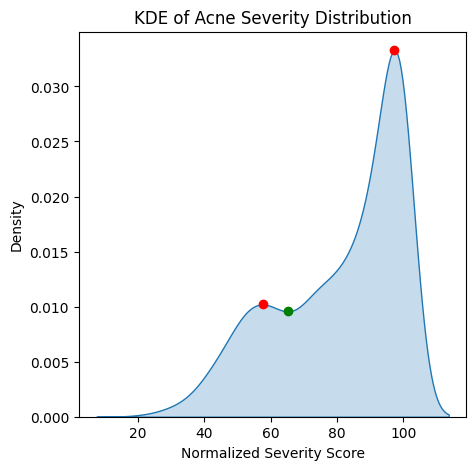

Do you want to view the data? Type Yes or No. Yes


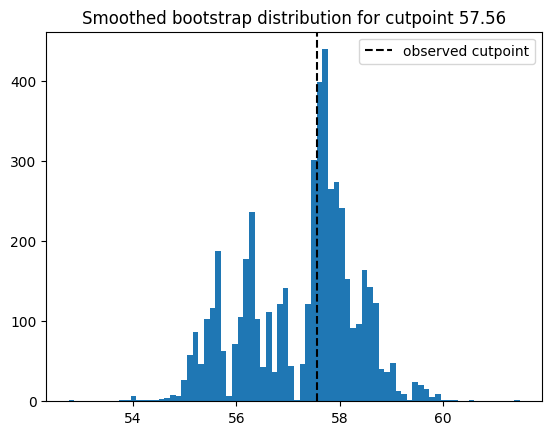

Cutpoint=57.5590, 95% CI=(55.1612,59.0271), MOE=1.9330


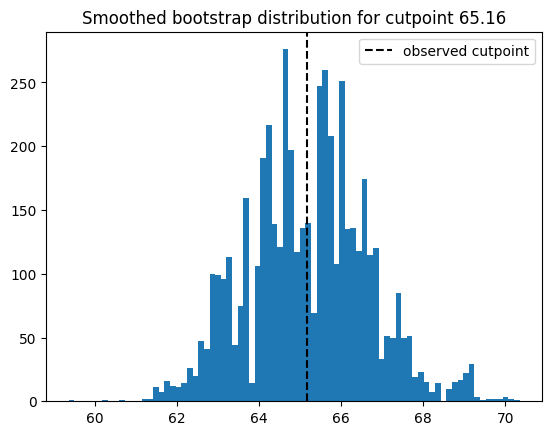

Cutpoint=65.1581, 95% CI=(62.5249,68.2597), MOE=2.8674


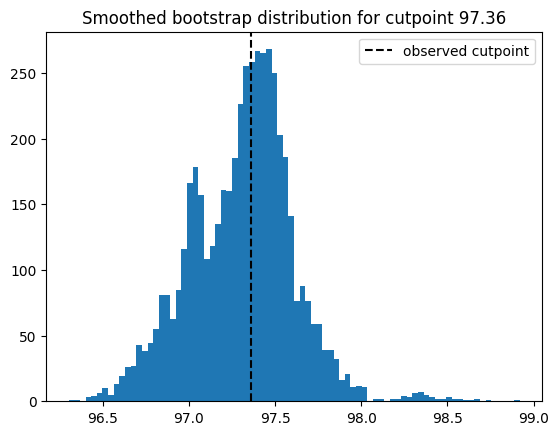

Cutpoint=97.3580, 95% CI=(96.7055,97.8713), MOE=0.5829


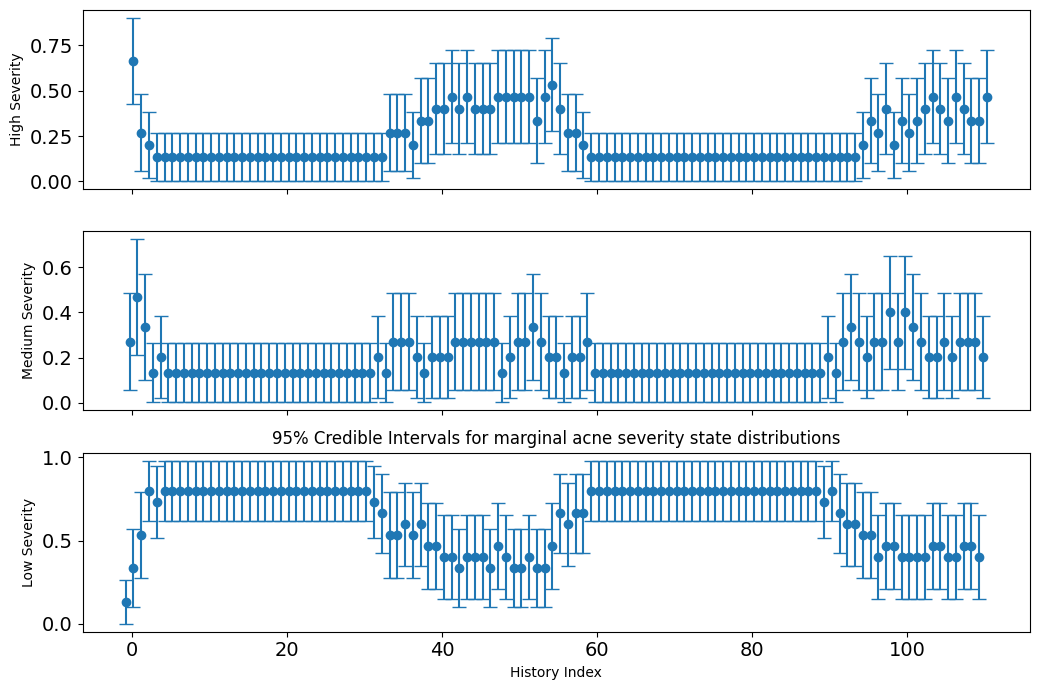

/var/folders/y9/4ydc08tj4g17pzwslm7db4c00000gp/T/ipykernel_34176/3591379785.py:38: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend(loc='upper right')


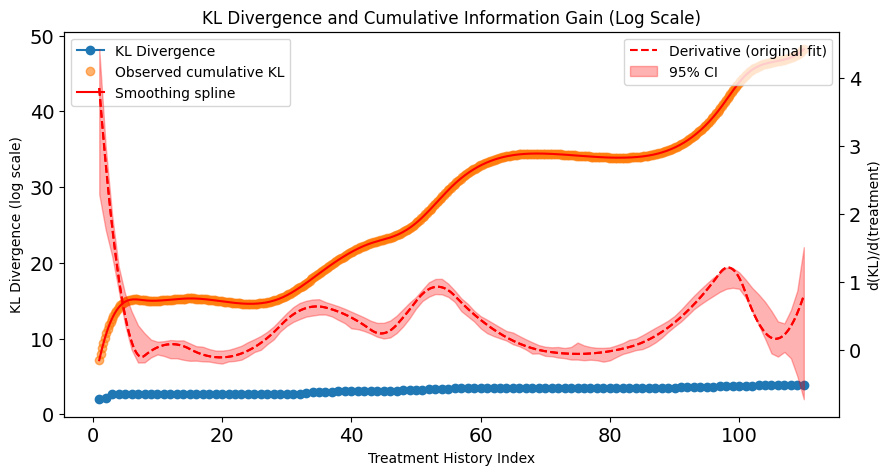

<Figure size 640x480 with 0 Axes>

ok
{'r_growth': np.float64(0.9999999999999996), 'K_CC': 1.0, 'k_antibiotics': np.float64(0.18420681743952366), 'k_sebum': np.float64(0.18420681743952366), 'I_bacterial_induction': np.float64(0.18420681743952366), 'I_decay_tstd': np.float64(0.18420681743952366), 'I_baseline_decay': np.float64(0.18420681743952366), 'r_I_production': np.float64(0.18420681743952366), 'r_cream_clean': np.float64(0.18420681743952366), 'noise': 0.01, 'w_sigma': 0.3, 'm_sigma': 0.5}


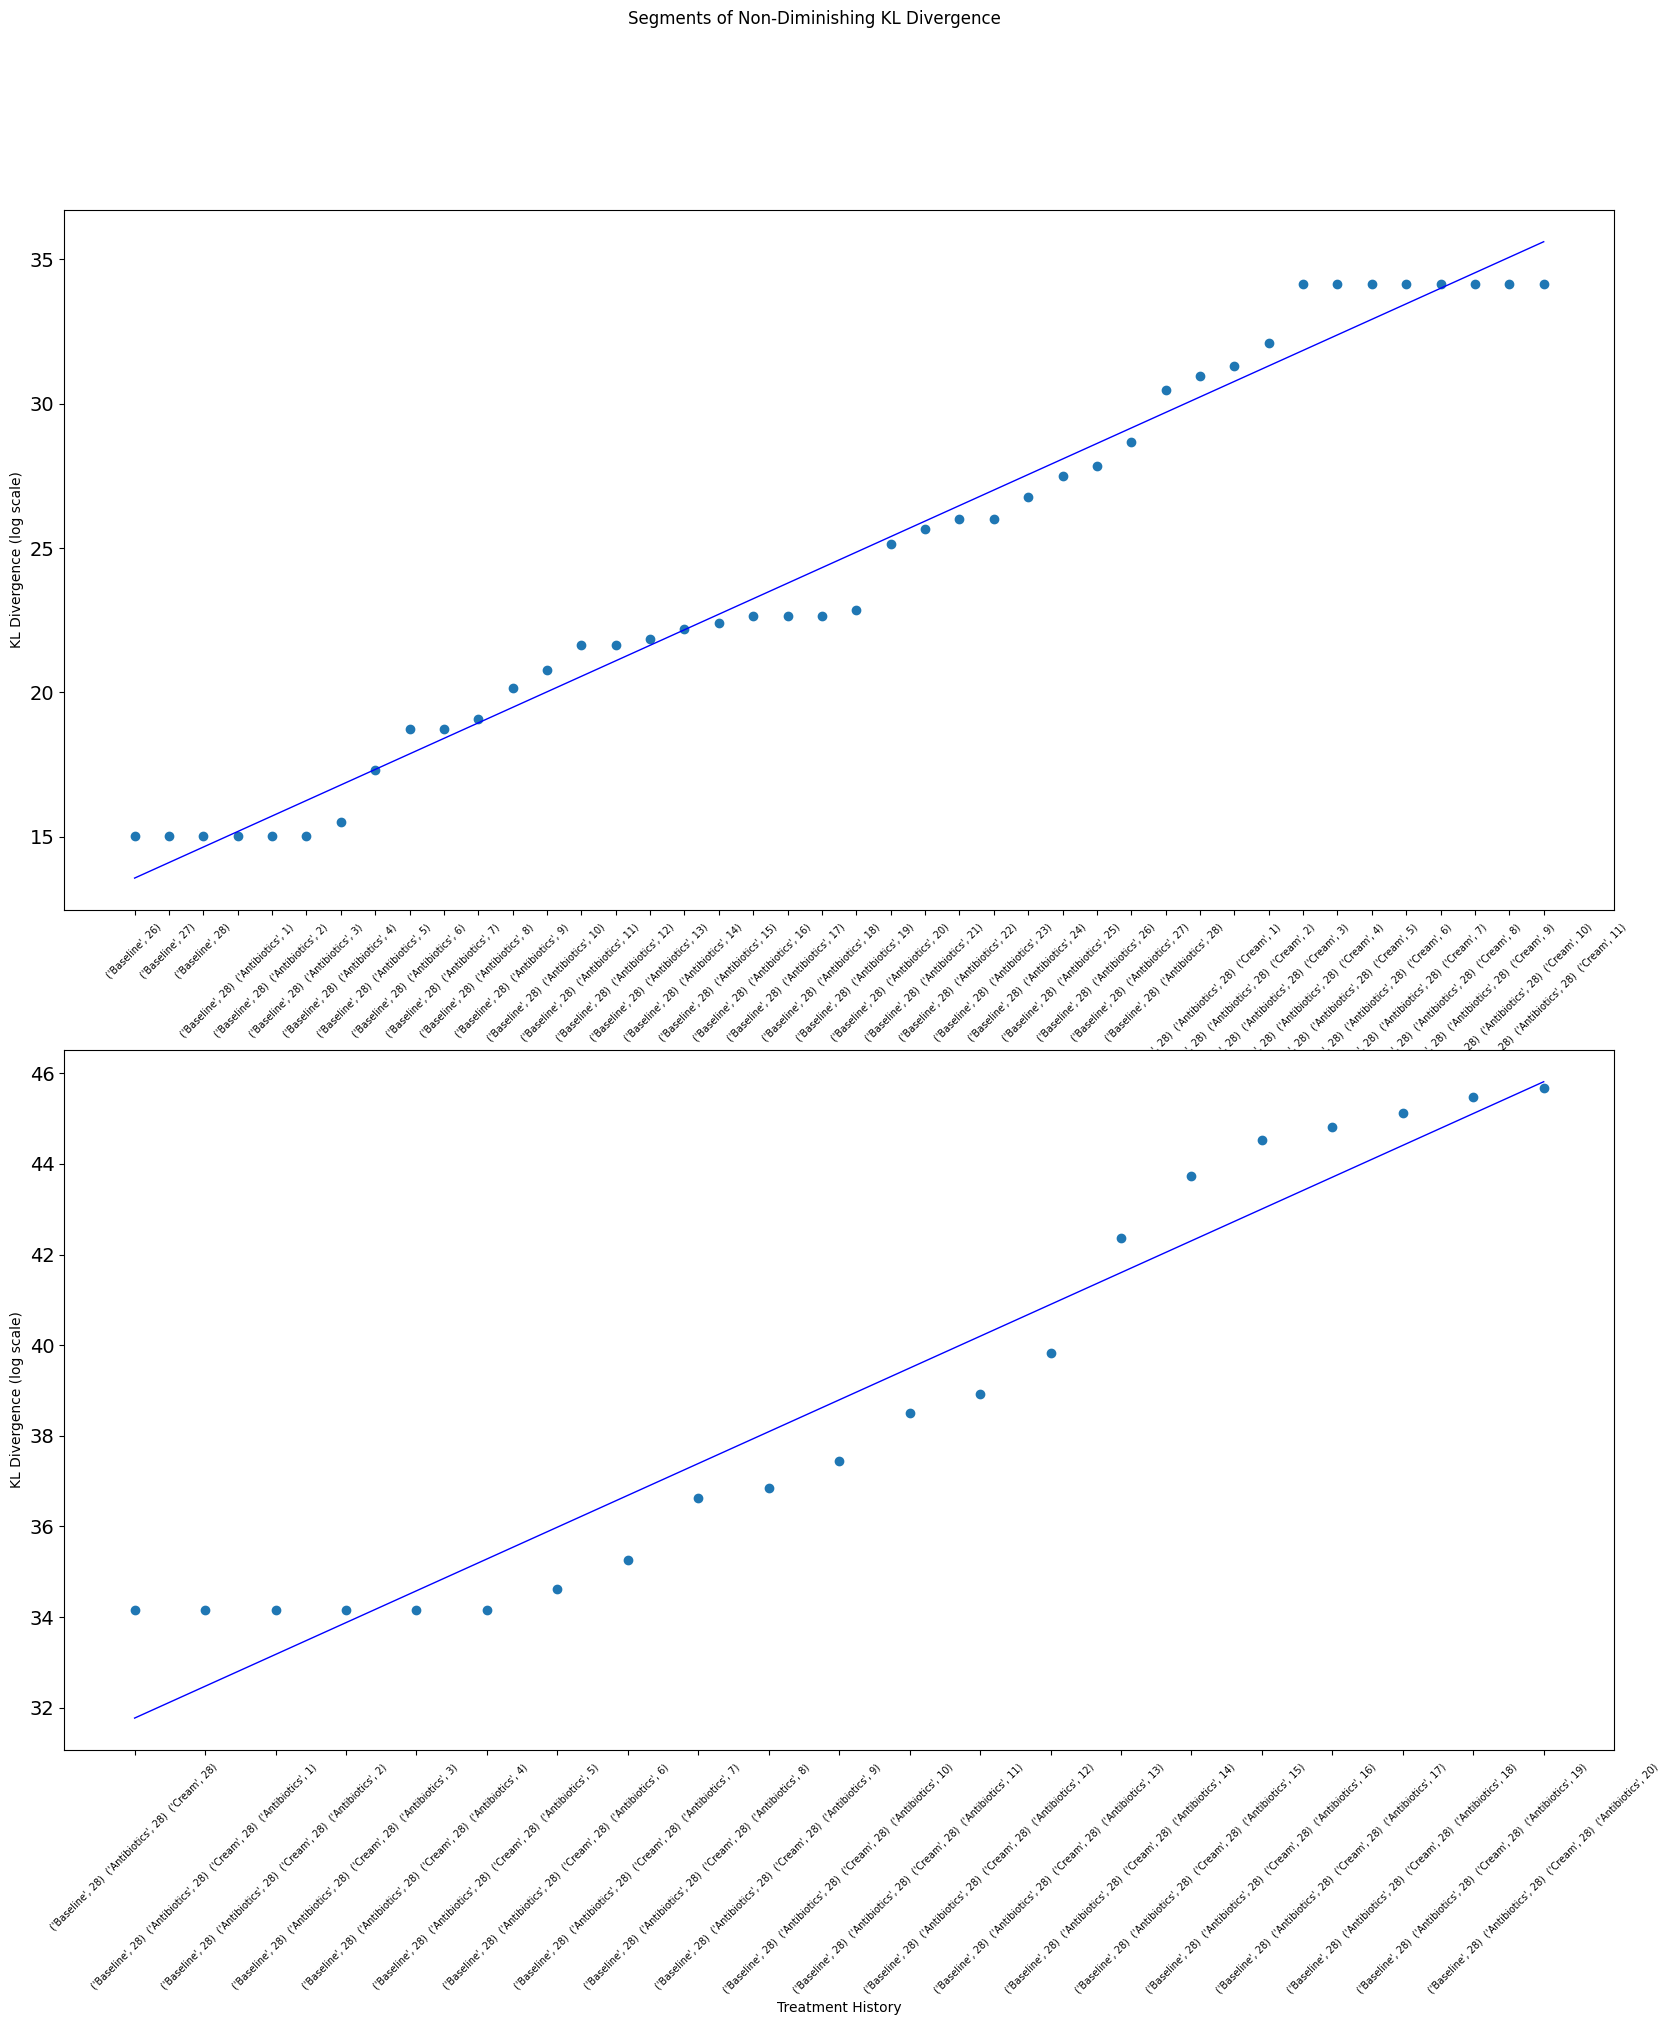

In [42]:
def main(this_raw_data_name, json_name):
    data_returns = data_parsing(this_raw_data_name)
    #this_data_visualization = data_visualization(data_returns[1], data_returns[0], data_returns[4], data_returns[3])
    these_ranges = data_returns[3]
    these_averages = data_returns[5]
    these_dirichlets = data_returns[6]

    view_plots = False
    user_input = input("Do you want to view the data? Type Yes or No.")
    
    if user_input == "Yes":
         view_plots = True
    if view_plots:
        
        this_data_visualization = data_visualization(data_returns[1], data_returns[0], data_returns[4], data_returns[3])
    if not view_plots:
        print("Ok, going on to modeling.")
    
    
    
    with open(json_name, "r") as icgs:
        initial_constant_guesses = json.load(icgs)
        this_model_config = {"scoring": np.random.randn(3, 3) * 0.02,
                        #column order: low severity change, medium, high. row order: #bacteria, inflammation, sebum.
    "biases": [0, 0, 0],
    "Q": np.eye(3) * (initial_constant_guesses["w_sigma"]**2),
    "R": np.eye(3) * (initial_constant_guesses["m_sigma"]**2)

}
           
        
    this_built_model = model_building(data_returns[1], initial_constant_guesses, these_dirichlets, these_averages, this_model_config)
    
    

#retrieving Acne04 dataset from Kaggle source (local download on machine)
this_raw_data_name = "sim_acne.csv"
if __name__ == "__main__":
    main(this_raw_data_name, "initial_constants.json")

In [43]:
def fit_piecewise_regression_and_plot_unused(points, splits):
    """This function actually splits a given array (here, cumulative KL divergence) into seperate regression models,
    using splits to partition the array and then fit a linear regression model to each one.
    It then calls plot_piecewise_regression_segments to plot the segments over the cumulative KL divergence Curve. Unused in this version."""
    split_points_and_indices = [(points[split[0]:split[1]+1], split) for split in splits]
    linear_model = LinearRegression()
    consecutive_models = [LinearRegression().fit(np.arange(len(one_split_points[0])).reshape(-1, 1),one_split_points[0].reshape(-1, 1))for one_split_points in split_points_and_indices]

    slopes = [which_model.coef_[0] for which_model in consecutive_models]
    